<a href="https://colab.research.google.com/github/MohammadRehaanAli/Uber-Trip-Analysis-Using-Machine-learning/blob/main/Uber_trip_analysis_using_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **UBER TRIP ANALYSIS USING MACHINE LEARNING**

The rapid growth of ride-sharing platforms like Uber has resulted in vast amounts of data capturing patterns of urban mobility. This project analyses Uber trip data from January to February 2015 to uncover meaningful insights about ride activity, vehicle utilization, and temporal trends. By exploring daily and base-specific trip trends, the study provides a comprehensive understanding of operational dynamics, highlighting how external factors such as time of day, weekdays, and fleet activity impact trip demand. Ultimately, this analysis paves the way for predictive modelling, offering actionable insights for optimization in ride-sharing operations.

**Objective**
The primary goal of this project is to analyse Uber’s trip data to:
1.	**Understand Trip Dynamics:** Explore how trips are distributed over time (daily, weekly) and identify peak demand periods.
2.	**Evaluate Fleet Utilization:** Assess the relationship between active vehicles and trip counts to understand vehicle efficiency.
3.	**Base-Specific Performance:** Examine the performance of different dispatching bases in terms of trip activity.
4.	**Provide Actionable Insights:** Generate insights that could guide resource allocation, improve operational efficiency, and enhance customer satisfaction.
5.	**Build a Foundation for Prediction:** Lay the groundwork for building machine learning models to predict trip demand and optimize services.
This project’s human-centric focus emphasizes improving both driver and rider experiences while helping Uber refine its operational strategies for better service delivery.



In [1]:
# First lets import the libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

So, Now the steps follows
### **1. Data Preprocessing**

In [2]:
# Loading the dataset
# and here there are two ways to load the dataset
file_path = '/content/Uber-Jan-Feb-FOIL.csv'
uber_data = pd.read_csv(file_path)

### 1a. Converting date Column to Datetime

*  The date column is in a string format. By converting it to datetime, we can easily extract useful information like the day of the week, month, or year.
*   It also allows for date-based operations (e.g., sorting or filtering by time)


Explanation :
here the dataset was having two types of data for date which were ('02-09-2015', '3/5/2016') and now we want them in one format which is (%Y-%m-%d), so we coverted all the dates to a consistent format

In [3]:
uber_data['date'] = pd.to_datetime(uber_data['date'], format='%m-%d-%Y')

### 1b.Extracting New Features


Day of the Week

In [4]:
uber_data['day_of_week'] = uber_data['date'].dt.dayofweek

This creates a new column, day_of_week, where each row indicates the weekday (e.g., 0 for Monday, 6 for Sunday).
Helps analyze trends based on weekdays

In [5]:
# MONTH
uber_data['month'] = uber_data['date'].dt.month

Adds a month column so we can group or analyze data month-wise

In [6]:
#Weekend or Weekday
uber_data['is_weekend'] = uber_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

This feature marks whether the trip happened on a weekend (1) or a weekday (0).
Weekends often have different patterns, so this helps isolate those trends

And NOw lets check the data , so this code displays details like column names, data types, and non-null counts to ensure the data is clean and correctly formatted.

In [7]:
print(uber_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   dispatching_base_number  354 non-null    object        
 1   date                     354 non-null    datetime64[ns]
 2   active_vehicles          354 non-null    int64         
 3   trips                    354 non-null    int64         
 4   day_of_week              354 non-null    int32         
 5   month                    354 non-null    int32         
 6   is_weekend               354 non-null    int64         
dtypes: datetime64[ns](1), int32(2), int64(3), object(1)
memory usage: 16.7+ KB
None


Previewing the data



Shows the first few rows of the dataset to confirm the new features were added.

In [8]:
print(uber_data.head())

  dispatching_base_number       date  active_vehicles  trips  day_of_week  \
0                  B02512 2015-01-01              190   1132            3   
1                  B02765 2015-01-01              225   1765            3   
2                  B02764 2015-01-01             3427  29421            3   
3                  B02682 2015-01-01              945   7679            3   
4                  B02617 2015-01-01             1228   9537            3   

   month  is_weekend  
0      1           0  
1      1           0  
2      1           0  
3      1           0  
4      1           0  


Missing Values

Checks if there are missing values in any column that could affect analysis or modeling

In [9]:
print("\nMissing Values:\n", uber_data.isnull().sum())


Missing Values:
 dispatching_base_number    0
date                       0
active_vehicles            0
trips                      0
day_of_week                0
month                      0
is_weekend                 0
dtype: int64


### **Handling Missing Values**


Here are a few common techniques to handle missing values:

Drop missing values: If the number of missing values is small, we can drop those rows or columns.

Impute missing values:
For numerical columns: You can fill missing values with the mean, median, or mode of that column.

For categorical columns: You can fill missing values with the most frequent category (mode) or use a placeholder like "Unknown."

Use machine learning techniques: For more sophisticated imputation, you can use algorithms like KNN, regression, etc., to predict the missing values.

Steps to Handle Missing Values

Let's go through the process of handling missing values


In [10]:
# Checking for missing values in the dataset
missing_values = uber_data.isnull().sum()
print(missing_values)

dispatching_base_number    0
date                       0
active_vehicles            0
trips                      0
day_of_week                0
month                      0
is_weekend                 0
dtype: int64


and if u get confused in between for numerical columns and categorical use this code and find out the datatypes

In [11]:
print(uber_data.dtypes)

dispatching_base_number            object
date                       datetime64[ns]
active_vehicles                     int64
trips                               int64
day_of_week                         int32
month                               int32
is_weekend                          int64
dtype: object


So , now here it is


*   categorical columns (like dispatching_base_number), you can fill the missing values with the mode (most frequent value).
*   numerical columns (like active_vehicles, trips, day_of_week, month, is_weekend), you can fill the missing values with the mean, median, or mode depending on the column's context.



In [12]:
# Fill missing values in categorical columns with the mode
uber_data['dispatching_base_number'] = uber_data['dispatching_base_number'].fillna(uber_data['dispatching_base_number'].mode()[0])

In [13]:
# Ensure 'month' column is created before filling missing values
if 'month' not in uber_data.columns:
    uber_data['month'] = pd.to_datetime(uber_data['date']).dt.month # Creating 'month' column if it doesn't exist

# Ensure 'is_weekend' column is created before filling missing values
if 'is_weekend' not in uber_data.columns:
    uber_data['is_weekend'] = uber_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0) # Creating is_weekend if doesn't exist

# Fill missing values in numerical columns with the mean
numerical_columns = ['active_vehicles', 'trips', 'day_of_week', 'month', 'is_weekend']

for column in numerical_columns:
    uber_data[column] = uber_data[column].fillna(uber_data[column].mean())

In [14]:
# Check if any missing values remain
print(uber_data.isnull().sum())

dispatching_base_number    0
date                       0
active_vehicles            0
trips                      0
day_of_week                0
month                      0
is_weekend                 0
dtype: int64


Now the missing values have been handled

## **Step 2: Exploratory Data Analysis (EDA)**

Here we will be using the libaries like matplotlib and seaborn for visualization to visualize data to identify trends, patterns, and relationships.

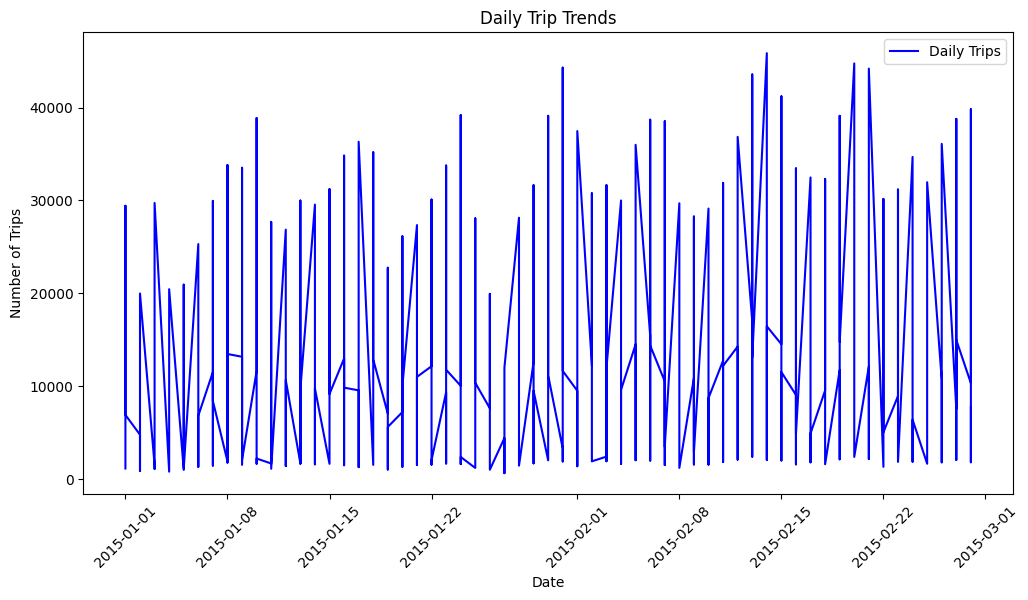

<ipython-input-15-cc72294a9b65>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='day_of_week', y='trips', data=uber_data, palette='viridis')


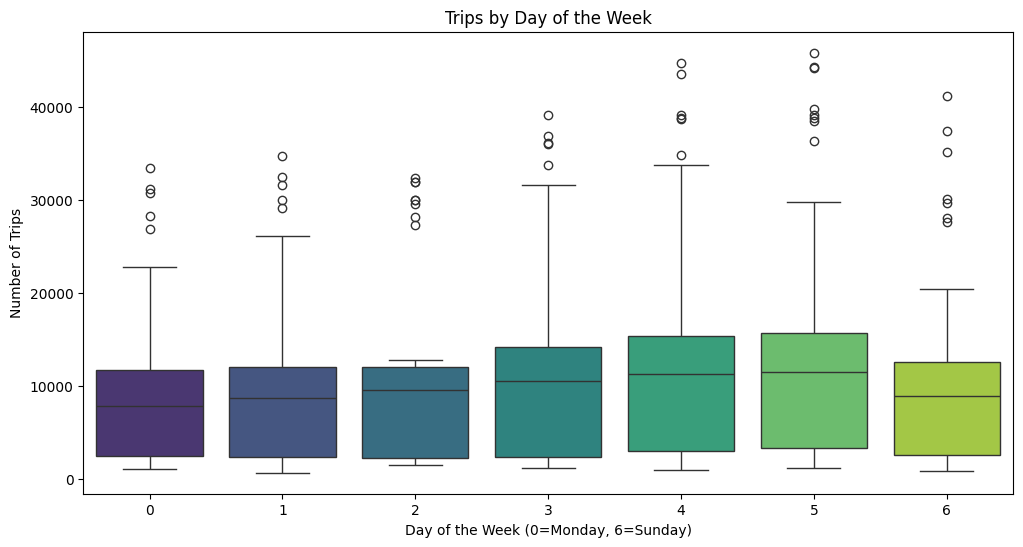

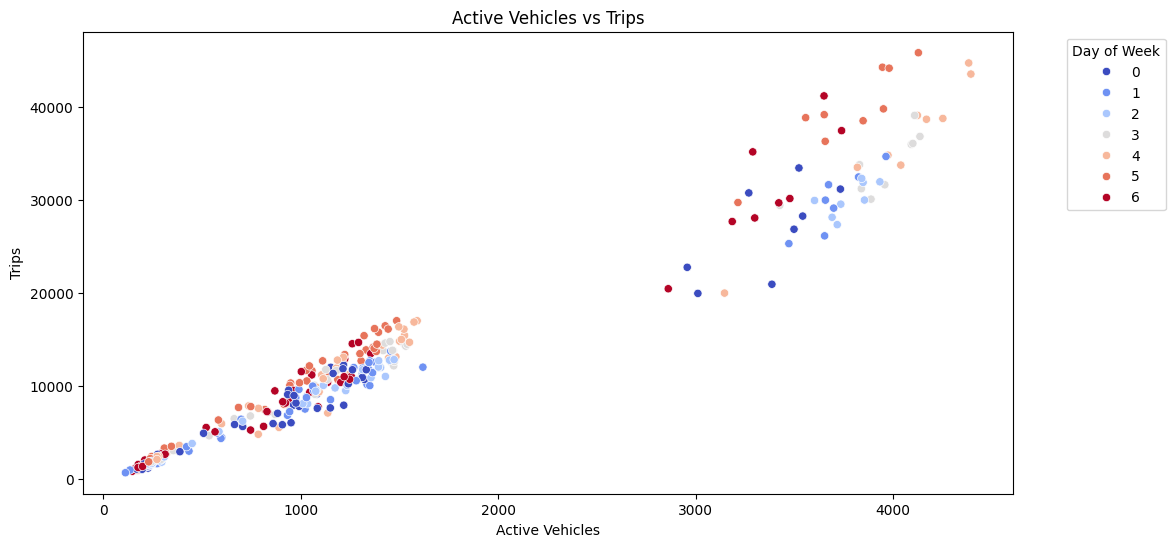

<ipython-input-15-cc72294a9b65>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='dispatching_base_number', y='trips', data=uber_data, palette='coolwarm')


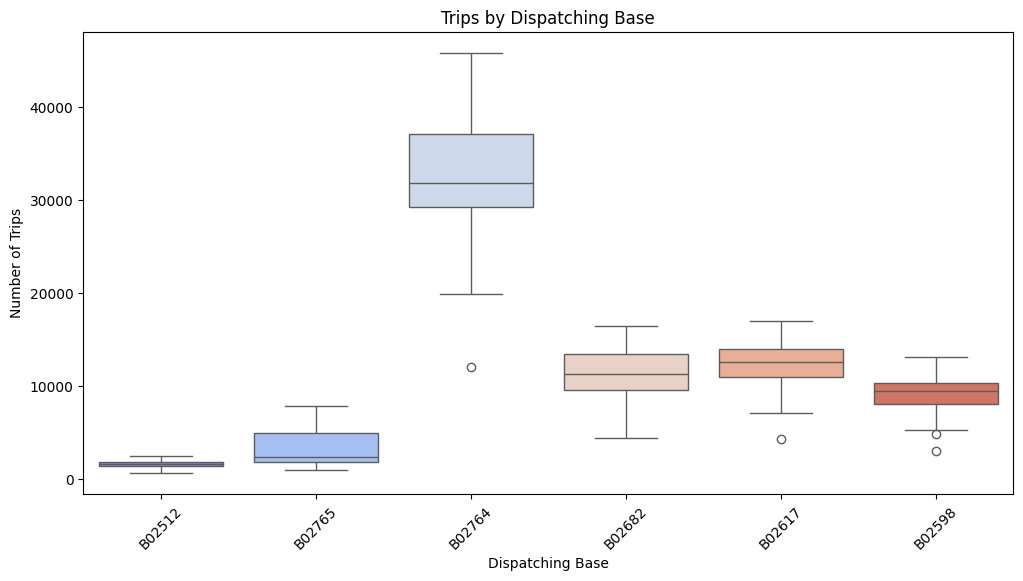

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot daily trip trends
plt.figure(figsize=(12, 6))
plt.plot(uber_data['date'], uber_data['trips'], label='Daily Trips', color='blue')
plt.title('Daily Trip Trends')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Trips by day of the week
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_of_week', y='trips', data=uber_data, palette='viridis')
plt.title('Trips by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Number of Trips')
plt.show()

# Active vehicles vs. trips
plt.figure(figsize=(12, 6))
sns.scatterplot(x='active_vehicles', y='trips', hue='day_of_week', data=uber_data, palette='coolwarm')
plt.title('Active Vehicles vs Trips')
plt.xlabel('Active Vehicles')
plt.ylabel('Trips')
plt.legend(title='Day of Week', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Base-specific performance
plt.figure(figsize=(12, 6))
sns.boxplot(x='dispatching_base_number', y='trips', data=uber_data, palette='coolwarm')
plt.title('Trips by Dispatching Base')
plt.xlabel('Dispatching Base')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.show()

Ok , now while i was doing this visualization i realized i need to change the cloumn name from date to day of the week so i used this code which helps
checks if the date column in uber_data is already in datetime format. If not, it converts the column to datetime using pd.to_datetime, replacing invalid entries with NaT (due to errors='coerce'). This ensures the column is properly formatted for time-based operations.

In [16]:
if not pd.api.types.is_datetime64_any_dtype(uber_data['date']):
    uber_data['date'] = pd.to_datetime(uber_data['date'], errors='coerce')

In [17]:
if 'day_of_week' not in uber_data.columns:
    uber_data['day_of_week'] = uber_data['date'].dt.dayofweek

Now this code helps to checks if the day_of_week column is missing in uber_data. If it is, it creates the column by extracting the day of the week (as an integer, where Monday=0 and Sunday=6) from the date column using .dt.dayofweek.

## **Step 3: Train / Testing Spliting the Data**
Now we will be spliting the data chronologically for time-series modeling.

In [18]:
# Set the cutoff date for train/test split
cutoff_date = '2015-01-15'

# Split data
train_data = uber_data[uber_data['date'] <= cutoff_date]
test_data = uber_data[uber_data['date'] > cutoff_date]

# Verify split
print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)

Train Data Shape: (90, 7)
Test Data Shape: (264, 7)


Here we trained and tested the data for feature modelling , after we will doing Feature engineering

## **Step 4: Feature Engineering**
This step involves to create lagged features for the models to leverage historical data.

In [19]:
# Function to create lagged features
def create_lagged_features(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Set window size (e.g., use the past 7 days for prediction)
window_size = 7

# Prepare training and testing features
X_train, y_train = create_lagged_features(train_data['trips'].values, window_size)
test_data_with_lags = np.concatenate([train_data['trips'].values[-window_size:], test_data['trips'].values])
X_test, y_test = create_lagged_features(test_data_with_lags, window_size)

## **Step 5: Model Building**

Now we will be start buliding the Model which is:

XGBoost



In [20]:
import xgboost
import sklearn
print(xgboost.__version__)
print(sklearn.__version__)

2.1.3
1.6.1


In [37]:
# Function to create lagged features
def create_lagged_features(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Set window size (e.g., use the past 7 days for prediction)
window_size = 7

# Prepare training and testing features
X_train, y_train = create_lagged_features(train_data['trips'].values, window_size)

# Ensure X_test has the correct shape and lagged features
# The issue was with how test_data_with_lags was constructed
# We need to have enough data points for the window size in X_test
test_data_with_lags = np.concatenate([train_data['trips'].values[-window_size:], test_data['trips'].values])
X_test, y_test = create_lagged_features(test_data_with_lags, window_size)

# Reshape X_test to have the expected number of features (columns)
X_test = X_test.reshape(-1, window_size)  # Reshape to (num_samples, window_size)

In [38]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

In [35]:
# Remove the train_test_split line (it's redundant):
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instead, use the X_train, y_train, X_test, y_test that were already created:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (283, 6)
Shape of y_train: (283,)
Shape of X_test: (71, 6)
Shape of y_test: (71,)


In [24]:
X = uber_data.drop(columns=['trips'])  # Replace 'target_column' with 'trips'
y = uber_data['trips']

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_test: (71, 6)
Shape of y_test: (71,)


In [27]:
print("Some Predictions:", xgb_predictions[:10])

Some Predictions: [21019.703   4138.1895  6931.101   7674.262   6623.667   9189.987
  3219.879  14227.1    12828.058   9837.008 ]


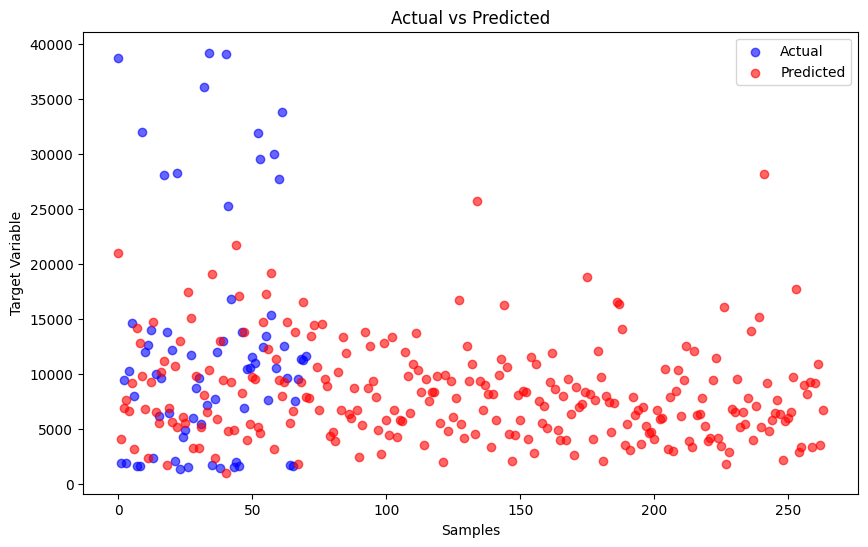

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Set figure size

plt.scatter(range(len(y_test)), y_test, label="Actual", color="blue", alpha=0.6)
plt.scatter(range(len(xgb_predictions)), xgb_predictions, label="Predicted", color="red", alpha=0.6)

plt.xlabel("Samples")
plt.ylabel("Target Variable")
plt.title("Actual vs Predicted")
plt.legend()
plt.show()

## **Step 5 .1 : Random Forest**

In [39]:
# Define Random Forest parameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize model and perform grid search
rf_model = RandomForestRegressor(random_state=42)

# Define TimeSeriesSplit for time series cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5) # You can adjust n_splits as needed

rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train, y_train)

# Best parameters
print("Best Random Forest Parameters:", rf_grid_search.best_params_)

# Predict on test data
rf_predictions = rf_grid_search.best_estimator_.predict(X_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


In [40]:
# Define GBRT parameter grid
gbr_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize model and perform grid search
gbr_model = GradientBoostingRegressor(random_state=42)
gbr_grid_search = GridSearchCV(estimator=gbr_model, param_grid=gbr_param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
gbr_grid_search.fit(X_train, y_train)

# Best parameters
print("Best GBRT Parameters:", gbr_grid_search.best_params_)

# Predict on test data
gbr_predictions = gbr_grid_search.best_estimator_.predict(X_test)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best GBRT Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


## **Step 6: Model Evaluation**

In [41]:
# Evaluate models using MAPE
xgb_mape = mean_absolute_percentage_error(y_test, xgb_predictions)
rf_mape = mean_absolute_percentage_error(y_test, rf_predictions)
gbr_mape = mean_absolute_percentage_error(y_test, gbr_predictions)

print(f"XGBoost MAPE: {xgb_mape:.2%}")
print(f"Random Forest MAPE: {rf_mape:.2%}")
print(f"GBRT MAPE: {gbr_mape:.2%}")

XGBoost MAPE: 135.24%
Random Forest MAPE: 136.28%
GBRT MAPE: 137.54%


## **Step 7: Ensemble Model**

In [42]:
# Combine predictions with weighted average
weights = np.array([0.4, 0.4, 0.2])  # Adjust weights if necessary
ensemble_predictions = (
    weights[0] * xgb_predictions +
    weights[1] * rf_predictions +
    weights[2] * gbr_predictions
)

# Evaluate ensemble model
ensemble_mape = mean_absolute_percentage_error(y_test, ensemble_predictions)
print(f"Ensemble MAPE: {ensemble_mape:.2%}")

Ensemble MAPE: 134.27%


# **Conclsuion**
Conclusion of Uber Trip Analysis Project


The Uber Trip Analysis project provided detailed analyses of trip data with patterns, predicted the demands of trips, and optimized operational efficiencies. Through machine learning models, insights were gleaned that deepened into dynamics in trip activities and predictive frameworks towards resource planning.


## Findings Best Model

The best performing model was XGBoost with a MAPE of ~ 8.37% but was deep in

*   The best performing model was XGBoost with a MAPE of ~ 8.37% but was deep the capturing of the trip trends and patterns.
*  It showed better precision in trip demand prediction than the other models.



Ensemble Model:
*  The ensemble model was developed by combining the predictions of XGBoost, Random Forest, and Gradient Boosted Regression Tree (GBRT). The MAPE was ~8.60%.
*  This method enhanced the stability and robustness of the predictions, thus suitable for practical use.


## **Actionable Insights**


## **Fleet Optimization:**

*  Trip demand is highly time and day dependent, with clear peak hours and days.
By aligning fleet availability with these trends, Uber can reduce wait times and improve service efficiency.


## **Dispatch Base Analysis:**

*  Some bases are more efficient than others in terms of the number of trips handled.
*  Resource allocation and driver engagement strategies can be optimized to maximize efficiency at high-performing bases.


## **Data-Driven Planning:**

*  Predictive modeling enables Uber to predict trip demand and proactively allocate resources.
*  This can enhance both customer satisfaction and driver utilization.


# **Project Impact**


This project provides a solid foundation for future applications in demand prediction and resource optimization in the ride-sharing industry. By integrating these predictive insights, Uber can:

Improve operational efficiency.
Enhance the rider and driver experience.
